Notebook Color Scheme:


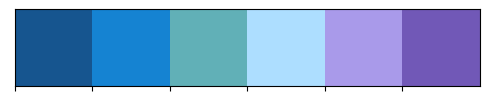

In [2]:
# Libraries
import os
import sys
import wandb
import time
import random
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html

warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'greatReef', '_wandb_kernel': 'aot'}

class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 14})

In [3]:
wandb.init(project="test-project", entity="jayanthguduru")

# Read training dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [5]:
test_df.head()

video_id  sequence  video_frame  sequence_frame image_id
0         3     17063            0               0      3-0
1         3     17063            1               1      3-1
2         3     17063            2               2      3-2

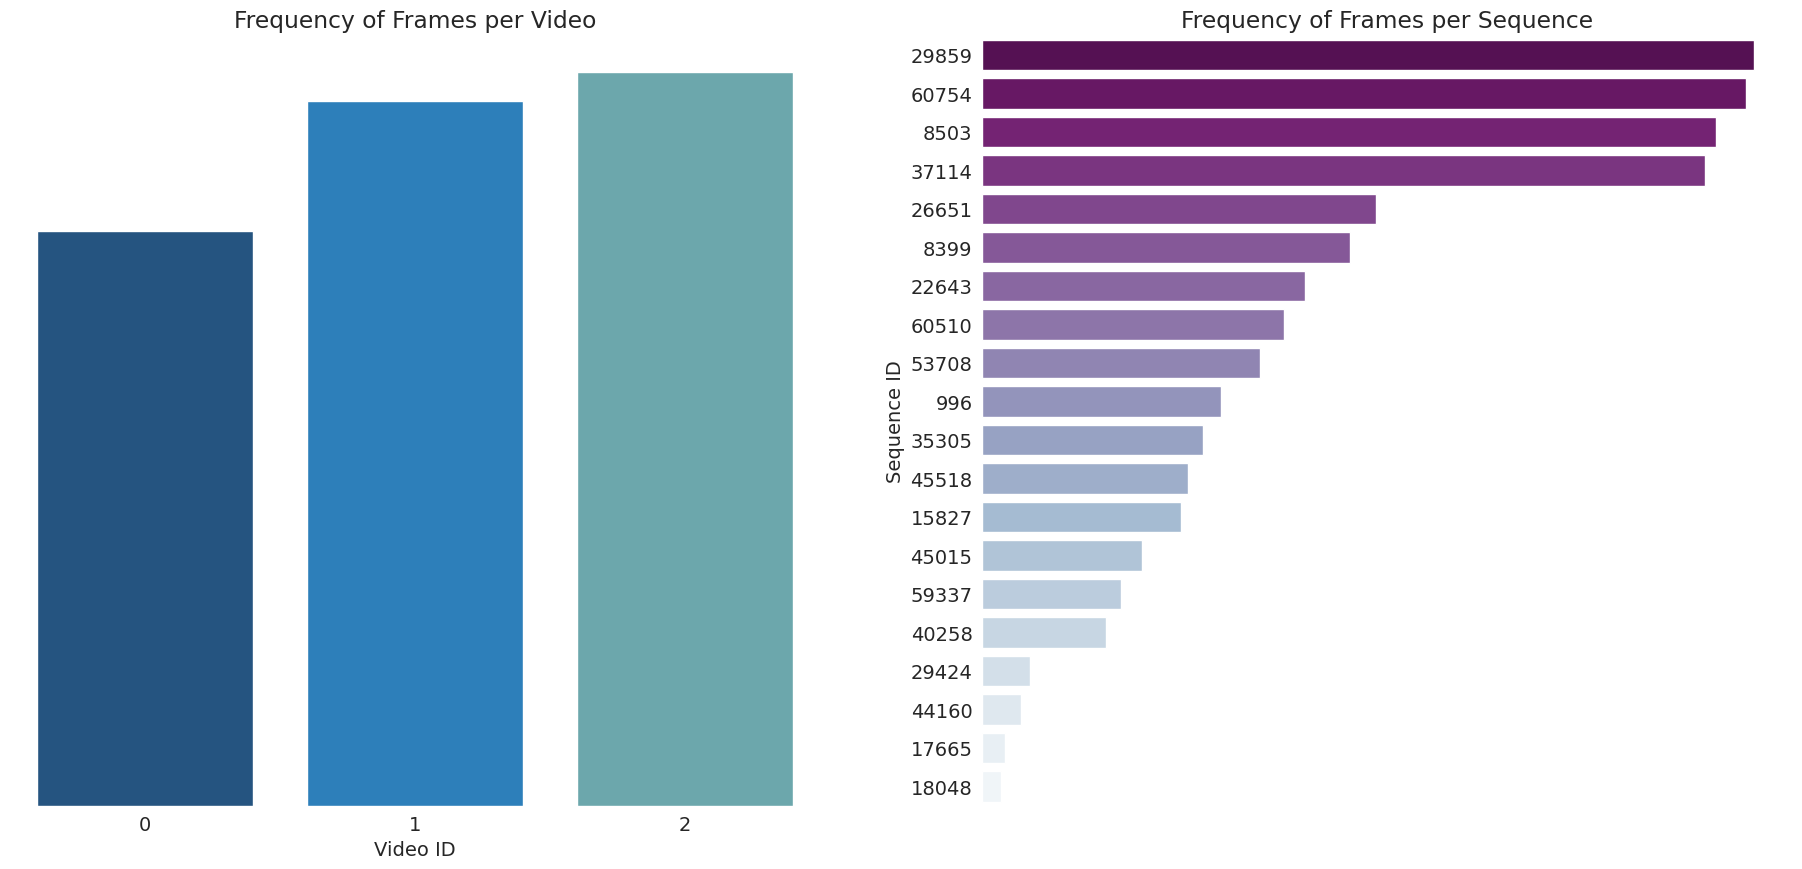

In [6]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

# --- Plot 1 ---
df1 = train_df["video_id"].value_counts().reset_index()

sns.barplot(data=df1, x="index", y="video_id", ax=ax1, palette=my_colors)
ax1.set_xlabel("Video ID")
ax1.set_ylabel("")
ax1.title.set_text("Frequency of Frames per Video")
ax1.set_yticks([])

# --- Plot 2  ---
df2 = train_df["sequence"].value_counts().reset_index()

sns.barplot(data=df2, y="index", x="sequence", order=df2["index"],
            ax=ax2, orient="h", palette="BuPu_r")
ax2.set_xlabel("")
ax2.set_ylabel("Sequence ID")
ax2.title.set_text("Frequency of Frames per Sequence")
ax2.set_xticks([])

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax1)
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax2)

In [7]:


# Calculate the number of total annotations within the frame
train_df["no_annotations"] = train_df["annotations"].apply(lambda x: len(eval(x)))


sequences = list(train_df["sequence"].unique())

plt.figure(figsize=(23,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.suptitle("Frequency of annotations on sequence length", fontsize = 20)

# Enumerate through all sequences
for k, sequence in enumerate(sequences):
    train_df[train_df["sequence"] == sequence]
    df_seq = train_df[train_df["sequence"] == sequence]
    
    plt.subplot(5, 4, k+1)
    plt.title(f"Sequence: {sequence}", fontsize = 12)
    plt.xlabel("Seq Frame", fontsize=10)
    plt.ylabel("No. Annot", fontsize=10)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
    sns.lineplot(x=df_seq["sequence_frame"], y=df_seq["no_annotations"],
                 color=my_colors[2], lw=3)

In [17]:
run = wandb.init(project="test-project", entity="jayanthguduru", name='ExampleImages', config=CONFIG, anonymous="allow")
base_folder = "train_images"
train_df["path"] = base_folder + "/video_" + \
                    train_df['video_id'].astype(str) + "/" +\
                    train_df['video_frame'].astype(str) +".jpg"

In [18]:
path = list(train_df[train_df["no_annotations"]==0]["path"])[0]
annot = list(train_df[train_df["no_annotations"]==0]["annotations"])[0]

In [19]:
def show_image(path, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")
    
    
# === 🐝W&B Log ===
def wandb_annotation(image, annotations):
    '''Source: https://www.kaggle.com/ayuraj/visualize-bounding-boxes-interactively
    image: the cv2.imread() output
    annotations: the original annotations from the train dataset'''
    
    all_annotations = []
    if annotations:
        for annot in eval(annotations):
            data = {"position": {
                            "minX": annot["x"],
                            "minY": annot["y"],
                            "maxX": annot["x"]+annot["width"],
                            "maxY": annot["y"]+annot["height"]
                        },
                    "class_id" : 1,
                    "domain" : "pixel"}
            all_annotations.append(data)
    
    return wandb.Image(image, 
                       boxes={"ground_truth": {"box_data": all_annotations}}
                      )

Path: train_images/video_0/5.jpg
Annotation: []
Frame:


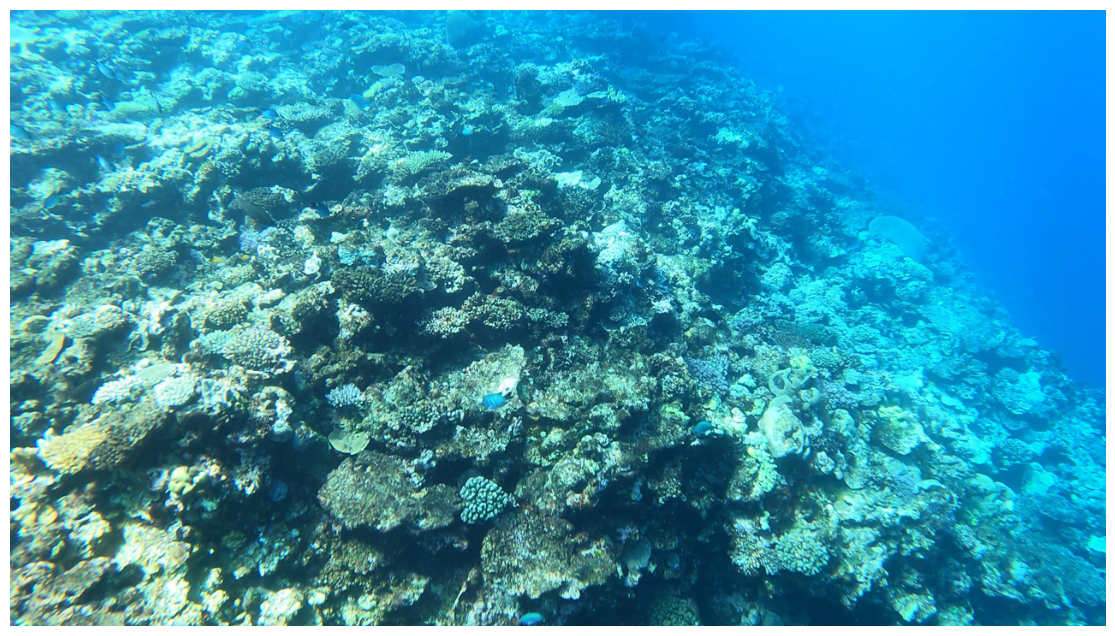

In [21]:
path = list(train_df[train_df["no_annotations"]==0]["path"])[5]
annot = list(train_df[train_df["no_annotations"]==0]["annotations"])[0]

# 🐝 Log Image to W&B
image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
wandb_images = []
wandb_images.append(wandb_annotation(image, annot))

print(color.S+"Path:"+color.E, path)
print(color.S+"Annotation:"+color.E, annot)
print(color.S+"Frame:"+color.E)
show_image(path, annot, axs=None)

In [55]:
def format_annotations(x):
    '''Changes annotations from format {x, y, width, height} to {x1, y1, x2, y2}.
    x: a string of the initial format.'''
    
    annotations = eval(x)
    new_annotations = []

    if annotations:
        for annot in annotations:
            new_annotations.append([annot["x"],
                                    annot["y"],
                                    annot["x"]+annot["width"],
                                    annot["y"]+annot["height"]
                                   ])
    
    if new_annotations: return str(new_annotations)
    else: return "[]"

In [56]:
train_df["f_annotations"] = train_df["annotations"].apply(lambda x: format_annotations(x))

In [57]:
def show_image_bbox(img, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    img: the output from cv2.imread()
    annot: FORMATED annotation'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    axs.imshow(img)

    if annot:
        for a in annot:
            rect = patches.Rectangle((a[0], a[1]), a[2]-a[0], a[3]-a[1], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")

In [58]:
class RandomHorizontalFlip(object):

    def __init__(self, p=0.5):
        # p = probability of the image to be flipped
        # set p = 1 to always flip
        self.p = p
        
    def __call__(self, img, bboxes):
        '''img : the image to be flipped
        bboxes : the annotations within the image'''
        
        # Convert bboxes
        bboxes = np.array(bboxes)
        
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        
        # If random number between 0 and 1 < probability p
        if random.random() < self.p:
            # Reverse image elements in the 1st dimension
            img =  img[:,::-1,:]
            bboxes[:,[0,2]] = bboxes[:,[0,2]] + 2*(img_center[[0,2]] - bboxes[:,[0,2]])
            
            # Convert the bounding boxes
            box_w = abs(bboxes[:,0] - bboxes[:,2])
            bboxes[:,0] -= box_w
            bboxes[:,2] += box_w
            
        return img, bboxes.tolist()

In [59]:
path = list(train_df[train_df["no_annotations"]==18]["path"])[0]

img_original = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
annot_original = eval(list(train_df[train_df["no_annotations"]==18]["f_annotations"])[0])

# Horizontal Flip
horizontal_flip = RandomHorizontalFlip(p=1)  
img_flipped, annot_flipped = horizontal_flip(img_original, annot_original)



# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Horizontal Flip", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("With Horizontal Flip", fontsize = 20)
show_image_bbox(img_flipped, annot_flipped, axs[1])

plt.tight_layout()
plt.show()

In [60]:
def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def clip_box(bbox, clip_box, alpha):
    """
    Clip the bounding boxes to the borders of an image
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox

In [61]:
def rotate_im(image, angle):
    '''image: numpy array of the image'''
    '''angle: a float that specifies the angle the image should be rotated.'''

    # Image dimensions
    (h, w) = image.shape[:2]
    # Image Centre
    (cX, cY) = (w // 2, h // 2)

    # Rotation Matrix from cv2
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    # Sine & Cosine - rotation components of the matrix
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # NEW Bounding Dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the Rotation
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

In [62]:
def get_corners(bboxes):
    '''bboxes: array of the original bounding boxes.'''
    
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    # Each bounding box is described by 8 coordinates x1,y1,x2,y2,x3,y3,x4,y4
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners


# === Box Rotation ===

def rotate_box(corners, angle, cx, cy, h, w):
    '''
    corners: output from get_corners()
    angle:  a float that specifies the angle the image should be rotated
    cx, cy: coordinates for the xenter of the image
    h, w: height and width of the image
    '''
    
    # corners = x1,y1,x2,y2,x3,y3,x4,y4
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    # Rotation Matrix from cv2
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    # Sine & Cosine - rotation components of the matrix
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # NEW Bounding Dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    calculated = calculated.reshape(-1,8)
    
    return calculated


# === Get the Enclosing Box ===

def get_enclosing_box(corners):
    '''corners: output from get_corners()'''
    
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    # Notation where each bounding box is determined by 4 coordinates or two corners
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

In [63]:
class RandomRotate(object):

    def __init__(self, angle = 10):
        
        self.angle = angle
        self.angle = (-self.angle, self.angle)
        
        
    def __call__(self, img, bboxes):

        # Convert bboxes
        bboxes = np.array(bboxes)
        
        # Compute the random angle
        angle = random.uniform(*self.angle)

        # width, height and center of the image
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2

        # Rotate the image
        img = rotate_im(img, angle)

        # --- Rotate the bounding boxes ---
        # Get the 4 point corner coordinates
        corners = get_corners(bboxes)
        corners = np.hstack((corners, bboxes[:,4:]))
        # Rotate the bounding box
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        # Get the enclosing (new bboxes)
        new_bbox = get_enclosing_box(corners)

        # Get scaling factors to clip the image and bboxes
        scale_factor_x = img.shape[1] / w
        scale_factor_y = img.shape[0] / h

        # Rescale the image - to w,h and not nW,nH
        img = cv2.resize(img, (w,h))

        # Clip boxes (in case there are any outside of the rotated image)
        bboxes[:,:4] = bboxes[:,:4] / [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)

        return img, bboxes.tolist()

In [64]:
random.seed(25)

# Translate
rotate = RandomRotate(angle=25) 
img_rotated, annot_rotated = rotate(img_original, annot_original)
# Show the Before and After
fig, axs = plt.subplots(1, 2, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"(Random) Image Rotation", fontsize = 20)

axs[0].set_title("Original Image", fontsize = 20)
show_image_bbox(img_original, annot_original, axs=axs[0])

axs[1].set_title("Rotated Image", fontsize = 20)
show_image_bbox(img_rotated, annot_rotated, axs[1])

plt.tight_layout()
plt.show()

In [84]:
train_df["path_images"] = "images/video_" + train_df["video_id"].astype(str) + "_" + \
                                                train_df["video_frame"].astype(str) + ".jpg"
train_df["path_labels"] = "labels/video_" + train_df["video_id"].astype(str) + "_" + \
                                                train_df["video_frame"].astype(str) + ".txt"

# Save the width and height of the images
# it is the same for the entire dataset
train_df["width"] = 1280
train_df["height"] = 720

# Simplify the annotation format
train_df["coco_bbox"] = train_df["annotations"].apply(lambda annot: [list(item.values()) for item in eval(annot)])

# Data Sample
train_df.sample(5, random_state=24)

video_id  sequence  video_frame  sequence_frame image_id  \
2375          0      8399         4298             560   0-4298   
8506          1     15827         2398             480   1-2398   
7142          1     60510          434             434    1-434   
8732          1     15827         2624             706   1-2624   
15763         2     37114          823             823    2-823   

                                             annotations  no_annotations  \
2375   [{'x': 641, 'y': 634, 'width': 74, 'height': 71}]               1   
8506                                                  []               0   
7142                                                  []               0   
8732                                                  []               0   
15763                                                 []               0   

                                path           f_annotations  \
2375   train_images/video_0/4298.jpg  [[641, 634, 715, 705]]   
8506   train_images/video_1/2398.jpg                      []   
7142    train_images/video_1/434.jpg                      []   
8732   train_images/video_1/2624.jpg                      []   
15763   train_images/video_2/823.jpg                      []   

                   path_images              path_labels  width  height  \
2375   images/video_0_4298.jpg  labels/video_0_4298.txt   1280     720   
8506   images/video_1_2398.jpg  labels/video_1_2398.txt   1280     720   
7142    images/video_1_434.jpg   labels/video_1_434.txt   1280     720   
8732   images/video_1_2624.jpg  labels/video_1_2624.txt   1280     720   
15763   images/video_2_823.jpg   labels/video_2_823.txt   1280     720   

                  coco_bbox  
2375   [[641, 634, 74, 71]]  
8506                     []  
7142                     []  
8732                     []  
15763                    []

In [85]:
train = train_df[train_df["no_annotations"]>0].reset_index(drop=True)

In [86]:
import shutil
for path in tqdm(train["path"].tolist()):
    split_path = path.split("/")
    # Retrieve the video id (0, 1, 2) and its frame number
    video_id = split_path[-2]
    video_frame = split_path[-1]
    # Create new image path
    path_image = "images{video_id}_{video_frame}"
    # Copy file from source (competition data) to destination (our new folder)
    shutil.copy(src=path, dst=path_image)

100%|██████████| 4919/4919 [19:32<00:00,  4.19it/s]


In [87]:
def coco2yolo(image_height, image_width, bboxes):
    """
    Converts a coco annotation format [xmin, ymin, w, h] to 
    the corresponding yolo format [xmid, ymid, w, h]
    
    image_height: height of the original image
    image_width: width of the original image
    bboxes: coco boxes to be converted
    return :: 
    
    inspo: https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train
    """
    
    bboxes = np.array(bboxes).astype(float)
    
    # Normalize xmin, w
    bboxes[:, [0, 2]]= bboxes[:, [0, 2]]/ image_width
    # Normalize ymin, h
    bboxes[:, [1, 3]]= bboxes[:, [1, 3]]/ image_height
    
    # Converstion (xmin, ymin) => (xmid, ymid)
    bboxes[:, [0, 1]] = bboxes[:, [0, 1]] + bboxes[:, [2, 3]]/2
    
    # Clip values (between 0 and 1)
    bboxes = np.clip(bboxes, a_min=0, a_max=1)
    
    return bboxes

In [22]:
yolo_bboxes = []
for k in tqdm(range(len(train))):
    row_data = train.iloc[k, :]
    height = row_data["height"]
    width = row_data["width"]
    coco_bbox = row_data["coco_bbox"]
    len_bbox = row_data["no_annotations"]
    # Create file and write in it
    with open(row_data["path_labels"],'w') as file:
        # In case there is an image with no present annotation
        if len_bbox == 0: 
            file.write("")
            continue
        # Convert coco format to yolo format
        yolo_bbox = coco2yolo(height, width, coco_bbox)
        yolo_bboxes.append(yolo_bbox)
        # Write annotations in file
        for i in range(len_bbox):
            annot = ["0"] + \
                    yolo_bbox[i].astype(str).tolist() + \
                    ([""] if i+1 == len_bbox else ["\n"])
            annot = " ".join(annot).strip()
            file.write(annot)
# Add yolo boxes to dataframe

NameError: name 'train' is not defined

In [20]:
train["yolo_bbox"] = yolo_bboxes

NameError: name 'yolo_bboxes' is not defined

In [89]:
train_data = train[train["video_id"].isin([0, 2])]
test_data = train[train["video_id"].isin([1])]

# Get path to images & labels
train_images = list(train_data["images"])
train_labels = list(train_data["labels"])

test_images = list(test_data["images"])
test_labels = list(test_data["labels"])

print(color.S+"Train Length:"+color.E, len(train_data), "\n" +
      color.S+"Test Length:"+color.E, len(test_data))

KeyError: 'images'